# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

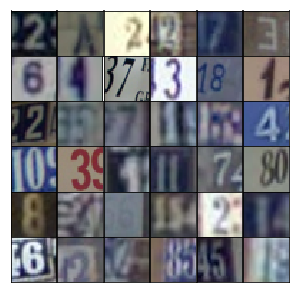

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. 
First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
# Scale works the same as Tanh
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y
            #yield x, y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(input_dim):
    # Input data to the modal
    inputs = tf.placeholder(tf.float32, (None, *input_dim), name=None)
    
    # Indices/output/target/classes data to the model
    indices = tf.placeholder(tf.int32, (None), name=None)    
    
    return inputs, indices

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [9]:
# tf.layers.conv2d(
#     inputs, ----------
#     filters, -------------
#     kernel_size, ------------
#     strides=(1, 1), ---------------
#     padding='valid', ------------
#     data_format='channels_last', -------------> NHWC and not NCHW
#     dilation_rate=(1, 1), -------------------
#     activation=None,
#     use_bias=True, ------------------
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), ------------------
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ---------------------
#     name=None,
#     reuse=None
# )

In [10]:
# Qfunction or qfunction, q/Q is quality and this is used as a classifier or q-learning or q-network
def qfunction(inputs, output_dim, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('qfunction', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=inputs, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it to the number of classes 
        # Let's imagine (4*4*512) is the number of classes.
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        #logits = tf.layers.dense(nl3_vec, 4*4*512)
        logits = tf.layers.dense(nl3_vec, output_dim) # this is for the classification task
        predictions = tf.nn.softmax(logits)
        # 4x4x512 now
        
        return logits, predictions

In [11]:
def generator(inputs, output_dim, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # Reshape it to start the convolutional stack
        h1 = tf.layers.dense(inputs, 4*4*512)
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        nl1_mat = tf.reshape(nl1, (-1, 4, 4, 512))
        # 4x4x512 now
        
        h2 = tf.layers.conv2d_transpose(inputs=nl1_mat, filters=256, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now
        
        h3 = tf.layers.conv2d_transpose(inputs=nl2, filters=128, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(inputs=nl3, filters=output_dim, kernel_size=5, strides=2, padding='same')        
        predictions = tf.tanh(logits) # inputs data is scaled!
        # 32x32x3 now

        # generated input or input fake
        return predictions

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [12]:
def discriminator(inputs, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=inputs, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        logits = tf.layers.dense(nl3_vec, 1)
        #predictions = tf.sigmoid(logits)
        
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [33]:
# This is to determin the number of classes
trainset['y'].max(), trainset['y'].min()

(10, 1)

In [36]:
def model_loss(inputs_real, input_dim, indices_real, indices_dim):
    """
    Get the loss for the discriminator and generator
    :param inputs_real: Images from the real dataset
    :param input_dim: Input image dimensions
    :param indices_real: Target/output class/label numbers
    :param indices_dim: Number of output classes or dimensions
    :return: A tuple of (qfunction accuracy, qfunction loss, generator loss, discriminator loss)
    """
    # Generating/reconstructing the fake inputs using real inputs
    q_logits, q_preds = qfunction(inputs=inputs_real, output_dim=indices_dim)
    inputs_fake = generator(inputs=q_preds, output_dim=input_dim)
    
    # Qfunction accuracy
    # Classification accuracy using logits and labels
    #     q_labels = tf.one_hot(depth=indices_dim, indices=indices_real)
    #     q_correct_preds = tf.equal(tf.argmax(input=q_logits, axis=1), tf.argmax(input=q_labels, axis=1))
    #     q_accuracy = tf.reduce_mean(tf.cast(q_correct_preds, tf.float32))

    # Qfunction loss using real and fake inputs
    # Classification error
    q_loss_class = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=q_logits, 
                                                   labels=tf.one_hot(depth=indices_dim, indices=indices_real)))
    # Reconstruction error
    # q_loss = tf.reduce_mean(tf.losses.mean_squared_error(predictions=input_fake, labels=input_real))
    q_loss_reconst = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=inputs_fake, labels=tf.sigmoid(inputs_real)))
    q_loss = q_loss_reconst + q_loss_class

    # Discriminator logits fake and real for G & D losses
    d_logits_fake = discriminator(inputs=tf.sigmoid(inputs_fake), reuse=False)
    d_logits_real = discriminator(inputs=tf.sigmoid(inputs_real), reuse=True)

    # Generator loss
    g_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.zeros_like(d_logits_real)))
    g_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    g_loss = g_loss_real + g_loss_fake

    # Discriminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return q_loss, g_loss, d_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [37]:
def model_opt(q_loss, g_loss, d_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param q_loss: Qfunction loss Tensor
    :param g_loss: Generator loss Tensor
    :param d_loss: Discriminator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [39]:
class GAN:
    def __init__(self, input_dim, indices_dim, learning_rate, beta1):
        tf.reset_default_graph()
        
        # Model inputs/data 
        self.inputs_real, self.indices_real = model_inputs(input_dim=input_dim)
        
        # Model losses/logits
        self.q_loss, self.g_loss, self.d_loss = model_loss(inputs_real=self.inputs_real, input_dim=input_dim[2],
                                                           indices_real=self.indices_real, indices_dim=indices_dim)

        # Model update/optimization
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, 
                                                       learning_rate=learning_rate, beta1=beta1)

Here is a function for displaying generated images.

In [40]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [56]:
def train(model, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    samples, losses = [], []
    #accs = []
    steps = 0

    # Creating a session for training
    with tf.Session() as sess:
        
        # Initialize the model variable if there is no model available to load/restore
        sess.run(tf.global_variables_initializer())
        
        # Restore/load the trained model
        #saver.restore(sess, './checkpoints/Auto-DCGAN.ckpt')
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
        
        # Number of epochs for updating the model/s
        for e in range(epochs):
            
            # Training batches
            for inputs_real, indices_real in dataset.batches(batch_size):
                steps += 1

                # Run optimizers
                feed_dict={model.inputs_real: inputs_real, model.indices_real: indices_real}
                _ = sess.run(model.q_opt, feed_dict)
                _ = sess.run(model.g_opt, feed_dict)
                _ = sess.run(model.d_opt, feed_dict)

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    #q_acc = model.q_acc.eval(feed_dict)
                    #q_acc = sess.run(model.q_acc, feed_dict)
                    q_loss = model.q_loss.eval(feed_dict)
                    g_loss = model.g_loss.eval(feed_dict)
                    d_loss = model.d_loss.eval(feed_dict)

                    print("Epoch {}/{}".format(e+1, epochs),
                          #"Qfunction Accuracy:{:.4f}".format(q_acc),
                          "Qfunction Loss:{:.4f}".format(q_loss),
                          "Generator Loss:{:.4f}".format(g_loss),
                          "Discriminator Loss:{:.4f}".format(d_loss))
                    
                    # Save losses to view after training
                    losses.append((q_loss, g_loss, d_loss))
                    #accs.append(q_acc)

                if steps % show_every == 0:
                    _, model_qpreds = qfunction(inputs=model.inputs_real, output_dim=10, reuse=True, training=False)
                    model_glogits = generator(inputs=model_qpreds, output_dim=3, reuse=True, training=False)
                    glogits = sess.run(model_glogits, feed_dict)
                    reconst_inputs = glogits
                    samples.append(reconst_inputs)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        # Save the trained model
        saver.save(sess, './checkpoints/model.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [57]:
# ADAM default parameters
# __init__(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )

In [58]:
# Dataset for the model
dataset = Dataset(trainset, testset)

In [59]:
dataset.train_y.shape, dataset.train_y.max()

((73257, 1), 10)

In [61]:
image_size = (32,32,3)
num_classes = 10
learning_rate = 0.001
beta1 = 0.5
batch_size = 128
epochs = 10
alpha = 0.1

# Create the network
model = GAN(input_dim=image_size, indices_dim=num_classes, learning_rate=learning_rate, beta1=beta1)

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
Epoch 1/10 Qfunction Loss:7.4189 Generator Loss:10.7267 Discriminator Loss:0.0797
Epoch 1/10 Qfunction Loss:14.0011 Generator Loss:9.1464 Discriminator Loss:0.0679
Epoch 1/10 Qfunction Loss:12.9223 Generator Loss:8.2631 Discriminator Loss:0.2231
Epoch 1/10 Qfunction Loss:9.4459 Generator Loss:9.8158 Discriminator Loss:0.0695
Epoch 1/10 Qfunction Loss:16.0917 Generator Loss:9.6779 Discriminator Loss:0.0945
Epoch 1/10 Qfunction Loss:6.9739 Generator Loss:7.3200 Discriminator Loss:0.1734
Epoch 1/10 Qfunction Loss:10.8907 Generator Loss:7.6104 Discriminator Loss:0.1846
Epoch 1/10 Qfunction Loss:4.6050 Generator Loss:7.6481 Discriminator Loss:0.2440
Epoch 1/10 Qfunction Loss:12.8677 Generator Loss:6.4579 Discriminator Loss:0.1804
Epoch 1/10 Qfunction Loss:14.0503 Generator Loss:11.0883 Discriminator Loss:0.6537


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


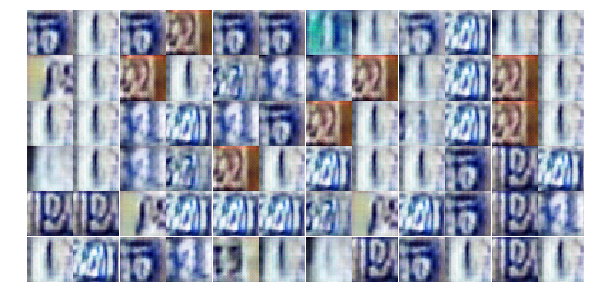

Epoch 1/10 Qfunction Loss:6.1947 Generator Loss:7.6025 Discriminator Loss:0.1304
Epoch 1/10 Qfunction Loss:11.2517 Generator Loss:9.1390 Discriminator Loss:0.0703
Epoch 1/10 Qfunction Loss:14.5377 Generator Loss:9.2602 Discriminator Loss:0.1004
Epoch 1/10 Qfunction Loss:14.1626 Generator Loss:7.5551 Discriminator Loss:0.1732
Epoch 1/10 Qfunction Loss:11.8868 Generator Loss:9.0461 Discriminator Loss:0.1007
Epoch 1/10 Qfunction Loss:14.0596 Generator Loss:8.1696 Discriminator Loss:0.1536
Epoch 1/10 Qfunction Loss:7.8620 Generator Loss:8.3558 Discriminator Loss:0.3386
Epoch 1/10 Qfunction Loss:18.9963 Generator Loss:9.1380 Discriminator Loss:0.2475
Epoch 1/10 Qfunction Loss:14.3624 Generator Loss:13.0942 Discriminator Loss:0.0102
Epoch 1/10 Qfunction Loss:6.9766 Generator Loss:10.2758 Discriminator Loss:0.1072


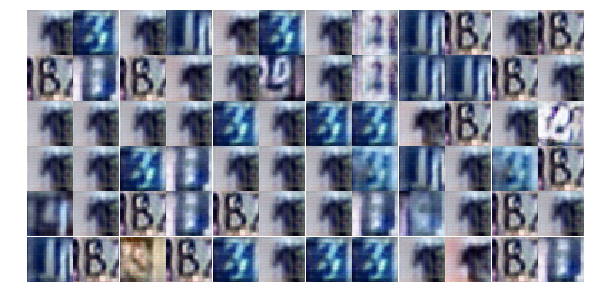

Epoch 1/10 Qfunction Loss:8.6717 Generator Loss:10.8451 Discriminator Loss:0.0718
Epoch 1/10 Qfunction Loss:11.7410 Generator Loss:10.9611 Discriminator Loss:0.1654
Epoch 1/10 Qfunction Loss:8.1026 Generator Loss:10.2929 Discriminator Loss:0.1187
Epoch 1/10 Qfunction Loss:18.8592 Generator Loss:7.6379 Discriminator Loss:0.1391
Epoch 1/10 Qfunction Loss:11.7250 Generator Loss:8.0652 Discriminator Loss:0.0885
Epoch 1/10 Qfunction Loss:15.6804 Generator Loss:9.7548 Discriminator Loss:0.3240
Epoch 1/10 Qfunction Loss:14.0048 Generator Loss:8.1143 Discriminator Loss:0.1095
Epoch 1/10 Qfunction Loss:18.4683 Generator Loss:8.6954 Discriminator Loss:0.0644
Epoch 1/10 Qfunction Loss:10.6877 Generator Loss:9.6278 Discriminator Loss:0.0855
Epoch 1/10 Qfunction Loss:14.2824 Generator Loss:7.0709 Discriminator Loss:0.1911


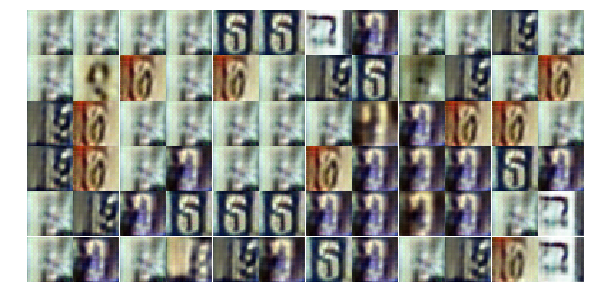

Epoch 1/10 Qfunction Loss:19.1926 Generator Loss:9.1447 Discriminator Loss:0.3044
Epoch 1/10 Qfunction Loss:9.6372 Generator Loss:8.2490 Discriminator Loss:0.1128
Epoch 1/10 Qfunction Loss:19.2661 Generator Loss:8.9107 Discriminator Loss:0.0907
Epoch 1/10 Qfunction Loss:6.1075 Generator Loss:9.8139 Discriminator Loss:0.0525
Epoch 1/10 Qfunction Loss:9.9860 Generator Loss:9.7398 Discriminator Loss:0.9158
Epoch 1/10 Qfunction Loss:10.6828 Generator Loss:10.9088 Discriminator Loss:0.1187
Epoch 1/10 Qfunction Loss:15.4818 Generator Loss:10.4735 Discriminator Loss:0.9303
Epoch 1/10 Qfunction Loss:11.2454 Generator Loss:10.2234 Discriminator Loss:0.0999
Epoch 1/10 Qfunction Loss:9.1668 Generator Loss:9.2386 Discriminator Loss:0.0474
Epoch 1/10 Qfunction Loss:21.6046 Generator Loss:7.3819 Discriminator Loss:0.2095


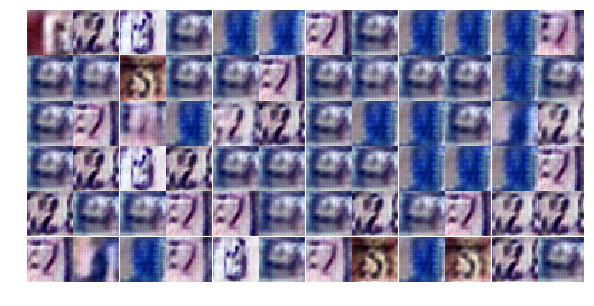

Epoch 1/10 Qfunction Loss:11.0718 Generator Loss:9.2870 Discriminator Loss:0.1466
Epoch 1/10 Qfunction Loss:8.2987 Generator Loss:6.8442 Discriminator Loss:0.1785
Epoch 1/10 Qfunction Loss:5.6028 Generator Loss:7.8951 Discriminator Loss:0.2401
Epoch 1/10 Qfunction Loss:12.6513 Generator Loss:9.1339 Discriminator Loss:0.3085
Epoch 1/10 Qfunction Loss:31.2240 Generator Loss:8.3486 Discriminator Loss:0.1228
Epoch 1/10 Qfunction Loss:11.0805 Generator Loss:11.9279 Discriminator Loss:0.1696
Epoch 1/10 Qfunction Loss:17.6158 Generator Loss:16.6606 Discriminator Loss:0.0743
Epoch 1/10 Qfunction Loss:14.4949 Generator Loss:12.8350 Discriminator Loss:0.0976
Epoch 1/10 Qfunction Loss:5.7216 Generator Loss:8.7834 Discriminator Loss:0.0948
Epoch 1/10 Qfunction Loss:8.7137 Generator Loss:7.8634 Discriminator Loss:0.1741


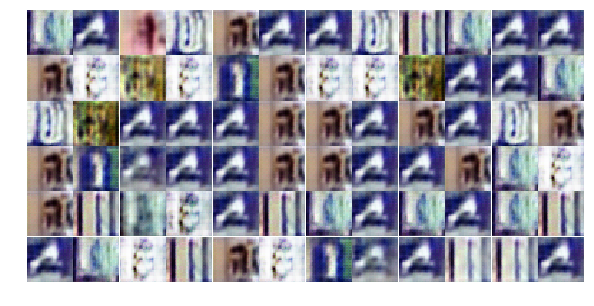

Epoch 1/10 Qfunction Loss:17.2214 Generator Loss:11.9106 Discriminator Loss:0.0248
Epoch 1/10 Qfunction Loss:8.6078 Generator Loss:8.9382 Discriminator Loss:0.1372
Epoch 1/10 Qfunction Loss:7.7665 Generator Loss:12.2444 Discriminator Loss:0.0680
Epoch 1/10 Qfunction Loss:6.6731 Generator Loss:8.7454 Discriminator Loss:0.1388
Epoch 1/10 Qfunction Loss:5.9509 Generator Loss:8.1321 Discriminator Loss:0.2900
Epoch 1/10 Qfunction Loss:13.1231 Generator Loss:12.5222 Discriminator Loss:0.0260
Epoch 1/10 Qfunction Loss:9.9683 Generator Loss:9.7814 Discriminator Loss:0.3731
Epoch 2/10 Qfunction Loss:10.7598 Generator Loss:8.4956 Discriminator Loss:0.1025
Epoch 2/10 Qfunction Loss:10.8467 Generator Loss:10.2102 Discriminator Loss:0.0732
Epoch 2/10 Qfunction Loss:11.5117 Generator Loss:9.0073 Discriminator Loss:0.0878


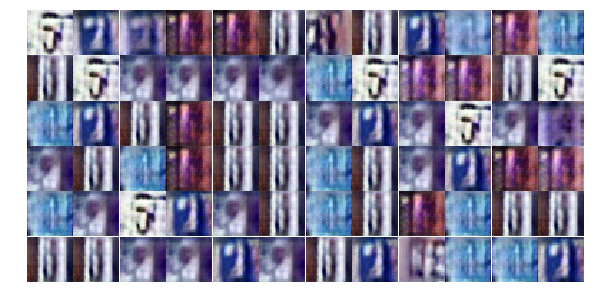

Epoch 2/10 Qfunction Loss:11.9692 Generator Loss:10.7196 Discriminator Loss:0.0503
Epoch 2/10 Qfunction Loss:9.8305 Generator Loss:9.6442 Discriminator Loss:0.5354
Epoch 2/10 Qfunction Loss:21.0049 Generator Loss:10.2929 Discriminator Loss:0.2787
Epoch 2/10 Qfunction Loss:10.4599 Generator Loss:9.4376 Discriminator Loss:0.1292
Epoch 2/10 Qfunction Loss:16.4820 Generator Loss:9.8676 Discriminator Loss:0.1048
Epoch 2/10 Qfunction Loss:22.7435 Generator Loss:7.5501 Discriminator Loss:0.1321
Epoch 2/10 Qfunction Loss:6.3268 Generator Loss:10.9372 Discriminator Loss:0.1067
Epoch 2/10 Qfunction Loss:8.6718 Generator Loss:9.1358 Discriminator Loss:0.0790
Epoch 2/10 Qfunction Loss:18.8571 Generator Loss:10.3239 Discriminator Loss:0.0573
Epoch 2/10 Qfunction Loss:15.9965 Generator Loss:9.4629 Discriminator Loss:0.1613


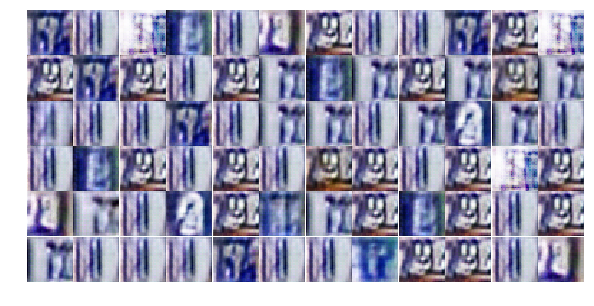

Epoch 2/10 Qfunction Loss:15.3436 Generator Loss:8.5561 Discriminator Loss:0.1049
Epoch 2/10 Qfunction Loss:8.7075 Generator Loss:8.2274 Discriminator Loss:0.1654
Epoch 2/10 Qfunction Loss:12.2706 Generator Loss:9.7259 Discriminator Loss:0.1821
Epoch 2/10 Qfunction Loss:13.7099 Generator Loss:10.8266 Discriminator Loss:0.0635
Epoch 2/10 Qfunction Loss:16.8895 Generator Loss:9.7440 Discriminator Loss:0.1052
Epoch 2/10 Qfunction Loss:11.9983 Generator Loss:9.2528 Discriminator Loss:0.0980
Epoch 2/10 Qfunction Loss:18.9419 Generator Loss:10.7430 Discriminator Loss:0.0491
Epoch 2/10 Qfunction Loss:20.0421 Generator Loss:8.5675 Discriminator Loss:0.1658
Epoch 2/10 Qfunction Loss:12.8919 Generator Loss:8.8673 Discriminator Loss:0.1206
Epoch 2/10 Qfunction Loss:15.3744 Generator Loss:7.6423 Discriminator Loss:0.2071


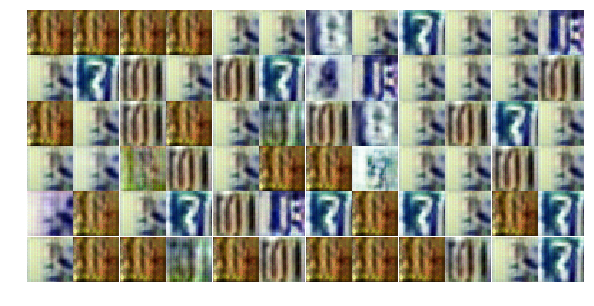

Epoch 2/10 Qfunction Loss:12.4236 Generator Loss:9.7458 Discriminator Loss:0.0609
Epoch 2/10 Qfunction Loss:15.2458 Generator Loss:10.2949 Discriminator Loss:0.4327
Epoch 2/10 Qfunction Loss:5.7452 Generator Loss:10.1350 Discriminator Loss:0.0726
Epoch 2/10 Qfunction Loss:21.6526 Generator Loss:13.6536 Discriminator Loss:0.5929
Epoch 2/10 Qfunction Loss:19.2240 Generator Loss:9.6041 Discriminator Loss:0.0712
Epoch 2/10 Qfunction Loss:14.6514 Generator Loss:9.9830 Discriminator Loss:0.0742
Epoch 2/10 Qfunction Loss:19.4593 Generator Loss:9.5278 Discriminator Loss:0.1160
Epoch 2/10 Qfunction Loss:16.5361 Generator Loss:9.2815 Discriminator Loss:0.1731
Epoch 2/10 Qfunction Loss:12.5293 Generator Loss:8.8374 Discriminator Loss:0.1053
Epoch 2/10 Qfunction Loss:21.1289 Generator Loss:10.1195 Discriminator Loss:0.0925


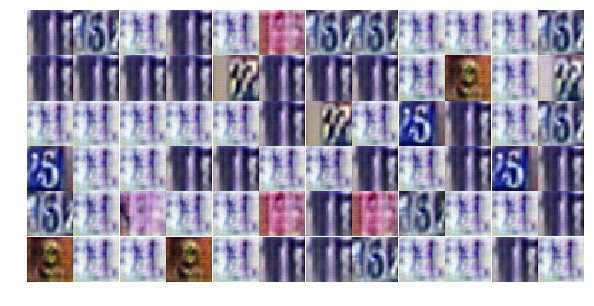

Epoch 2/10 Qfunction Loss:15.6257 Generator Loss:10.4608 Discriminator Loss:0.0499
Epoch 2/10 Qfunction Loss:10.3761 Generator Loss:8.3819 Discriminator Loss:0.2068
Epoch 2/10 Qfunction Loss:16.0824 Generator Loss:8.3122 Discriminator Loss:0.1634
Epoch 2/10 Qfunction Loss:14.6045 Generator Loss:9.3572 Discriminator Loss:0.2034
Epoch 2/10 Qfunction Loss:10.8669 Generator Loss:8.6944 Discriminator Loss:0.1518
Epoch 2/10 Qfunction Loss:8.7201 Generator Loss:10.6867 Discriminator Loss:0.0560
Epoch 2/10 Qfunction Loss:7.2353 Generator Loss:8.9620 Discriminator Loss:0.0959
Epoch 2/10 Qfunction Loss:8.5548 Generator Loss:10.3365 Discriminator Loss:0.0340
Epoch 2/10 Qfunction Loss:22.7348 Generator Loss:9.1692 Discriminator Loss:0.2071
Epoch 2/10 Qfunction Loss:12.7062 Generator Loss:11.0871 Discriminator Loss:0.1276


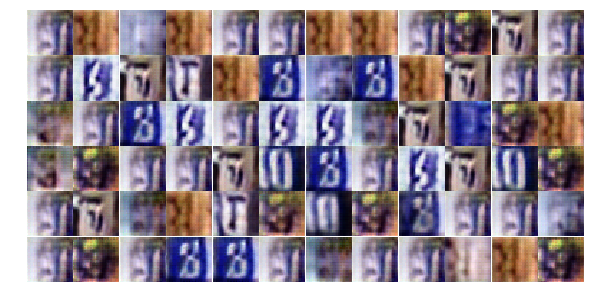

Epoch 2/10 Qfunction Loss:13.6023 Generator Loss:9.6860 Discriminator Loss:0.0437
Epoch 2/10 Qfunction Loss:22.1998 Generator Loss:9.3389 Discriminator Loss:0.0678
Epoch 2/10 Qfunction Loss:19.4711 Generator Loss:14.9822 Discriminator Loss:0.0769
Epoch 2/10 Qfunction Loss:16.9144 Generator Loss:13.9725 Discriminator Loss:0.3216
Epoch 2/10 Qfunction Loss:12.9131 Generator Loss:10.8854 Discriminator Loss:0.1088
Epoch 2/10 Qfunction Loss:18.7160 Generator Loss:9.3398 Discriminator Loss:0.3349
Epoch 2/10 Qfunction Loss:16.2952 Generator Loss:8.3400 Discriminator Loss:0.0929
Epoch 2/10 Qfunction Loss:12.5099 Generator Loss:10.4593 Discriminator Loss:0.0417
Epoch 2/10 Qfunction Loss:8.9790 Generator Loss:10.8486 Discriminator Loss:0.2111
Epoch 2/10 Qfunction Loss:11.6019 Generator Loss:10.2062 Discriminator Loss:0.0400


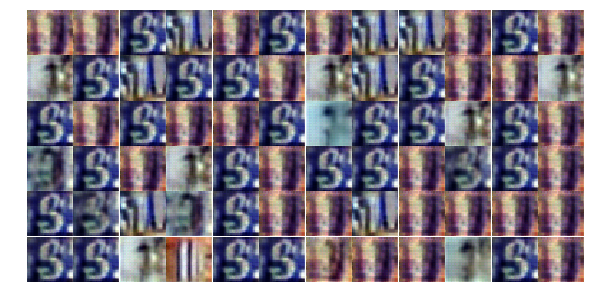

Epoch 2/10 Qfunction Loss:20.7763 Generator Loss:7.7758 Discriminator Loss:0.1430
Epoch 2/10 Qfunction Loss:14.6813 Generator Loss:7.8628 Discriminator Loss:0.1488
Epoch 2/10 Qfunction Loss:19.6338 Generator Loss:12.7317 Discriminator Loss:0.0184
Epoch 2/10 Qfunction Loss:16.4711 Generator Loss:8.3901 Discriminator Loss:0.1165
Epoch 3/10 Qfunction Loss:9.3028 Generator Loss:12.7863 Discriminator Loss:0.0916
Epoch 3/10 Qfunction Loss:9.3379 Generator Loss:9.4945 Discriminator Loss:0.0645
Epoch 3/10 Qfunction Loss:6.7654 Generator Loss:12.8880 Discriminator Loss:0.0141
Epoch 3/10 Qfunction Loss:16.3239 Generator Loss:10.0610 Discriminator Loss:0.0328
Epoch 3/10 Qfunction Loss:10.5630 Generator Loss:9.4670 Discriminator Loss:0.0706
Epoch 3/10 Qfunction Loss:23.2188 Generator Loss:9.3961 Discriminator Loss:0.0734


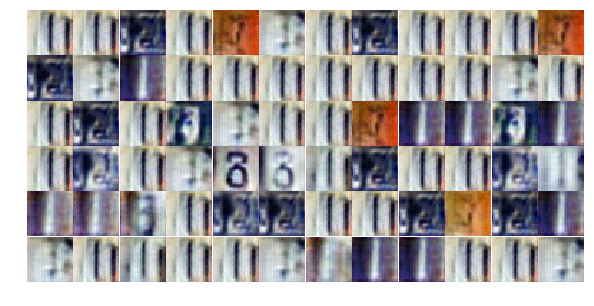

Epoch 3/10 Qfunction Loss:22.9417 Generator Loss:10.0227 Discriminator Loss:0.1012
Epoch 3/10 Qfunction Loss:9.4753 Generator Loss:9.9172 Discriminator Loss:0.0859
Epoch 3/10 Qfunction Loss:5.0313 Generator Loss:9.7487 Discriminator Loss:0.2143
Epoch 3/10 Qfunction Loss:19.5549 Generator Loss:11.2138 Discriminator Loss:0.0269
Epoch 3/10 Qfunction Loss:20.1148 Generator Loss:10.6388 Discriminator Loss:0.0698
Epoch 3/10 Qfunction Loss:27.5099 Generator Loss:11.4027 Discriminator Loss:0.5346
Epoch 3/10 Qfunction Loss:6.4934 Generator Loss:6.5073 Discriminator Loss:0.2076
Epoch 3/10 Qfunction Loss:21.9266 Generator Loss:12.7771 Discriminator Loss:0.0366
Epoch 3/10 Qfunction Loss:14.3087 Generator Loss:10.2988 Discriminator Loss:0.1147
Epoch 3/10 Qfunction Loss:8.9754 Generator Loss:9.3276 Discriminator Loss:0.0454


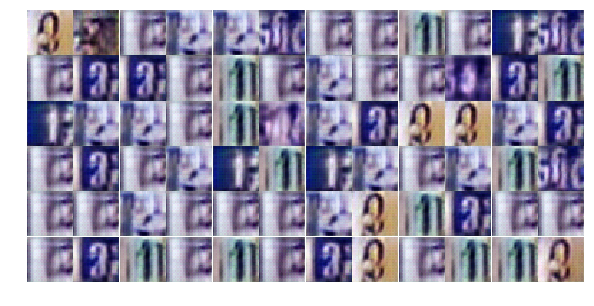

Epoch 3/10 Qfunction Loss:8.9096 Generator Loss:10.9363 Discriminator Loss:0.0400
Epoch 3/10 Qfunction Loss:20.5186 Generator Loss:9.9819 Discriminator Loss:0.0733
Epoch 3/10 Qfunction Loss:9.7479 Generator Loss:8.3730 Discriminator Loss:0.1146
Epoch 3/10 Qfunction Loss:13.0718 Generator Loss:10.1774 Discriminator Loss:0.0522
Epoch 3/10 Qfunction Loss:21.5935 Generator Loss:10.3967 Discriminator Loss:0.5903
Epoch 3/10 Qfunction Loss:18.2181 Generator Loss:11.4921 Discriminator Loss:0.0384
Epoch 3/10 Qfunction Loss:15.9987 Generator Loss:10.1614 Discriminator Loss:0.1010
Epoch 3/10 Qfunction Loss:19.2882 Generator Loss:15.2110 Discriminator Loss:1.0316
Epoch 3/10 Qfunction Loss:16.6526 Generator Loss:11.0795 Discriminator Loss:0.3294
Epoch 3/10 Qfunction Loss:6.4463 Generator Loss:9.1727 Discriminator Loss:0.0776


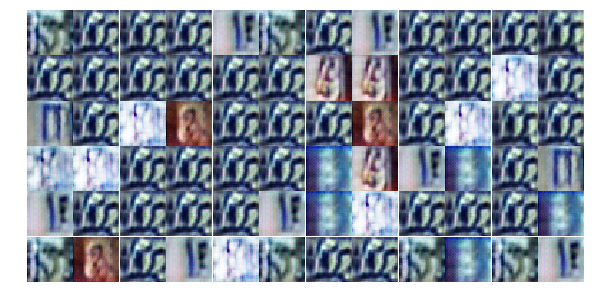

Epoch 3/10 Qfunction Loss:12.5190 Generator Loss:8.8188 Discriminator Loss:0.0820
Epoch 3/10 Qfunction Loss:22.2563 Generator Loss:9.4517 Discriminator Loss:0.0477
Epoch 3/10 Qfunction Loss:14.9826 Generator Loss:9.4060 Discriminator Loss:0.0686
Epoch 3/10 Qfunction Loss:6.0883 Generator Loss:8.0164 Discriminator Loss:0.2281
Epoch 3/10 Qfunction Loss:8.6681 Generator Loss:9.9020 Discriminator Loss:0.0710
Epoch 3/10 Qfunction Loss:11.2833 Generator Loss:10.1301 Discriminator Loss:0.2513
Epoch 3/10 Qfunction Loss:14.9819 Generator Loss:9.6365 Discriminator Loss:0.1360
Epoch 3/10 Qfunction Loss:27.9941 Generator Loss:10.8958 Discriminator Loss:0.0386
Epoch 3/10 Qfunction Loss:19.8268 Generator Loss:15.8262 Discriminator Loss:2.6124
Epoch 3/10 Qfunction Loss:23.1304 Generator Loss:13.8863 Discriminator Loss:0.0225


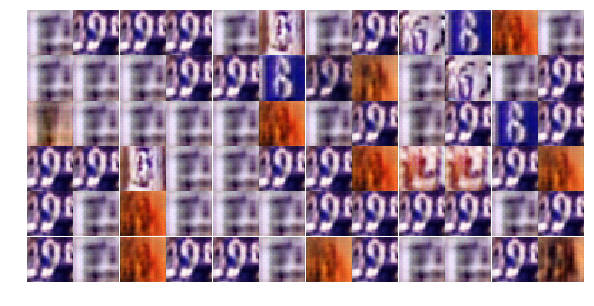

Epoch 3/10 Qfunction Loss:14.0694 Generator Loss:9.6174 Discriminator Loss:0.2351
Epoch 3/10 Qfunction Loss:6.9948 Generator Loss:9.0614 Discriminator Loss:0.0501
Epoch 3/10 Qfunction Loss:7.3684 Generator Loss:9.5479 Discriminator Loss:0.0747
Epoch 3/10 Qfunction Loss:14.5581 Generator Loss:9.7453 Discriminator Loss:0.0827
Epoch 3/10 Qfunction Loss:12.6676 Generator Loss:9.5345 Discriminator Loss:0.0961
Epoch 3/10 Qfunction Loss:8.5978 Generator Loss:10.0030 Discriminator Loss:0.0585
Epoch 3/10 Qfunction Loss:12.1832 Generator Loss:11.3654 Discriminator Loss:2.6723
Epoch 3/10 Qfunction Loss:10.0192 Generator Loss:10.8225 Discriminator Loss:0.2268
Epoch 3/10 Qfunction Loss:27.5384 Generator Loss:9.7624 Discriminator Loss:0.2019
Epoch 3/10 Qfunction Loss:8.5547 Generator Loss:8.8918 Discriminator Loss:0.1039


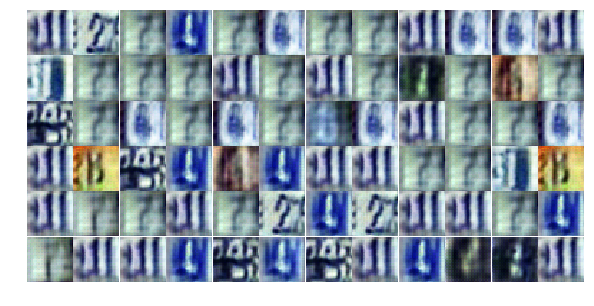

Epoch 3/10 Qfunction Loss:9.0849 Generator Loss:11.7612 Discriminator Loss:0.0305
Epoch 3/10 Qfunction Loss:15.7448 Generator Loss:8.4530 Discriminator Loss:0.0801
Epoch 3/10 Qfunction Loss:11.3975 Generator Loss:8.1464 Discriminator Loss:0.1045
Epoch 3/10 Qfunction Loss:15.7945 Generator Loss:9.6866 Discriminator Loss:0.0516
Epoch 3/10 Qfunction Loss:13.6903 Generator Loss:14.3570 Discriminator Loss:0.0372
Epoch 3/10 Qfunction Loss:10.5827 Generator Loss:11.0487 Discriminator Loss:0.0310
Epoch 3/10 Qfunction Loss:17.0729 Generator Loss:10.3066 Discriminator Loss:0.0676
Epoch 3/10 Qfunction Loss:10.1386 Generator Loss:12.3284 Discriminator Loss:0.0423
Epoch 3/10 Qfunction Loss:9.0437 Generator Loss:10.1738 Discriminator Loss:0.0516
Epoch 3/10 Qfunction Loss:12.9986 Generator Loss:12.6679 Discriminator Loss:0.0344


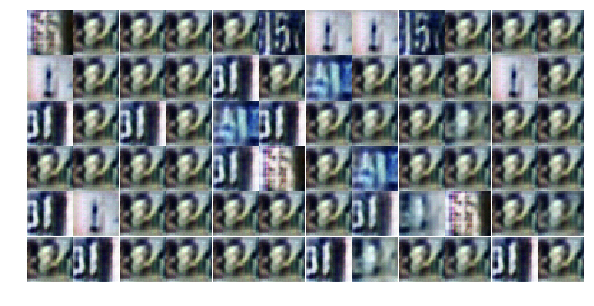

In [ ]:
losses, samples = train(model=model, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
losses_norm = (losses_ - losses_.mean(axis=0))/losses_.std(axis=0)
# print(losses_.shape, losses_norm.shape, losses_norm.dtype, losses_norm.dtype)
plt.plot(losses_norm.T[0], label='Generator', alpha=0.5)
plt.plot(losses_norm.T[1], label='Discriminator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
plt.plot(losses_.T[0], label='Generator', alpha=0.5)
plt.plot(losses_.T[1], label='Discriminator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

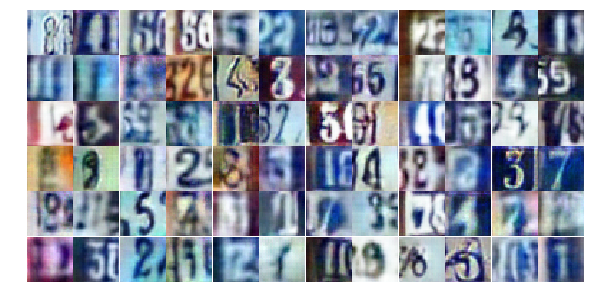

In [19]:
# Standard DCGAN
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))